# Visualizing keypoints

This notebook was originally taken from [NCNet](https://github.com/ignacio-rocco/ncnet/blob/master/point_transfer_demo.ipynb) and modified to work with ANCNet

# Imports

In [1]:
from __future__ import print_function, division
import os
from os.path import exists, join, basename
import numpy as np
import scipy as sc
import scipy.misc
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset

from lib.model import ImMatchNet,MutualMatching
from lib.normalization import NormalizeImageDict
from lib.torch_util import save_checkpoint, str_to_bool
from lib.point_tnf import corr_to_matches
from lib.point_tnf import normalize_axis, unnormalize_axis, bilinearInterpPointTnf
from lib.plot import plot_image

# CUDA
use_cuda = torch.cuda.is_available()

# Load pretrained model

In [2]:
checkpoint_path='models/ancnet_86_11.pth.tar'

checkpoint = torch.load(
    checkpoint_path, map_location=lambda storage, loc: storage
)
checkpoint["state_dict"] = OrderedDict(
    [
        (k.replace("vgg", "model"), v)
        for k, v in checkpoint["state_dict"].items()
    ]
)

model = ImMatchNet(
        use_cuda=use_cuda,
        feature_extraction_cnn='resnet101',
        checkpoint=checkpoint,
        ncons_kernel_sizes=[5, 5, 5],
        ncons_channels= [1, 16, 16, 1],
        pss=1,
        noniso=3,
    )


model.eval()
model.FeatureExtraction.eval()


for param in model.NeighConsensus.parameters():
    param.requires_grad = False
print('Done')

Copying weights...
Done!
Done


# Dataset

In [3]:
from lib.pf_dataset import PFPascalDataset
Dataset = PFPascalDataset
csv_file = 'image_pairs/test_pairs.csv'    
eval_dataset_path='datasets/pf-pascal/'
image_size=400
feature_size=int(image_size*0.0625)

dataset = Dataset(csv_file=os.path.join(eval_dataset_path, csv_file),
                  dataset_path=eval_dataset_path,
                  transform=NormalizeImageDict(['source_image','target_image']),
                  output_size=(image_size,image_size))

# Evaluate model

/home/taesiri/anaconda3/envs/deep36/lib/python3.6/site-packages/torch/nn/functional.py:3891: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/home/taesiri/anaconda3/envs/deep36/lib/python3.6/site-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


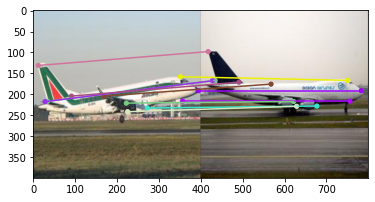

14


In [4]:
# draw sample
idx=np.random.randint(len(dataset))
sample=dataset[idx]
src=sample['source_image']
tgt=sample['target_image']
tgt_pts = Variable(sample['target_points'],requires_grad=False)
src_pts = Variable(sample['source_points'],requires_grad=False)

# ground truth annotations
valid_pts=tgt_pts[0,:]!=-1
tgt_pts=torch.cat((tgt_pts[0,:][valid_pts].view(1,1,-1),tgt_pts[1,:][valid_pts].view(1,1,-1)),1)
tgt_pts[0,0,:]=normalize_axis(tgt_pts[0,0,:],sample['target_im_size'][1])
tgt_pts[0,1,:]=normalize_axis(tgt_pts[0,1,:],sample['target_im_size'][0])

valid_pts=src_pts[0,:]!=-1
src_pts=torch.cat((src_pts[0,:][valid_pts].view(1,1,-1),src_pts[1,:][valid_pts].view(1,1,-1)),1)
src_pts[0,0,:]=normalize_axis(src_pts[0,0,:],sample['source_im_size'][1])
src_pts[0,1,:]=normalize_axis(src_pts[0,1,:],sample['source_im_size'][0])

# evaluate model on image pair
batch_tnf={'source_image':Variable(src.unsqueeze(0)),'target_image':Variable(tgt.unsqueeze(0))}

if use_cuda:
    src_pts = src_pts.cuda()
    tgt_pts = tgt_pts.cuda()
    batch_tnf['source_image']=batch_tnf['source_image'].cuda()
    batch_tnf['target_image']=batch_tnf['target_image'].cuda()
    
corr4d=model(batch_tnf)

# compute matches from output
c2m=corr_to_matches
xA,yA,xB,yB,sB=c2m(corr4d,do_softmax=True)
warped_points = bilinearInterpPointTnf((xA,yA,xB,yB),tgt_pts)

# display result
im=plot_image(torch.cat((batch_tnf['target_image'],batch_tnf['source_image']),3),0,return_im=True)
plt.imshow(im)
tgt_pts[0,0,:] = unnormalize_axis(tgt_pts[0,0,:],tgt.shape[2])
tgt_pts[0,1,:] = unnormalize_axis(tgt_pts[0,1,:],tgt.shape[1])
warped_points[0,0,:] = unnormalize_axis(warped_points[0,0,:],src.shape[2])
warped_points[0,1,:] = unnormalize_axis(warped_points[0,1,:],src.shape[1])

for i in range(tgt_pts.shape[2]):
    xa = float(tgt_pts[0,0,i])
    ya = float(tgt_pts[0,1,i])
    xb = float(warped_points[0,0,i])+tgt.shape[2]
    yb = float(warped_points[0,1,i])
    c=np.random.rand(3)
    plt.gca().add_artist(plt.Circle((xa,ya), radius=5, color=c))
    plt.gca().add_artist(plt.Circle((xb,yb), radius=5, color=c))
    plt.plot([xa, xb], [ya, yb], c=c, linestyle='-', linewidth=1.5)    
    
plt.show()
print(idx)